# ensemble

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import glob
import tqdm

In [106]:
df = pd.read_csv("../input/shopee-product-matching/train_fold.csv")
df = df[df["fold"] == 0]
tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
df['target'] = df.label_group.map(tmp)


In [107]:
posting_id = df["posting_id"].values

In [4]:
def get_cosine_similarity(embeddings):
    normed_emb = normalize(embeddings).astype(np.float16)
    distances = np.matmul(normed_emb, normed_emb.T).T
    
    return distances

In [5]:
def get_cv(df, similarity_matrix, threshold, posting_id, indices=None, pred_name="pred", min_n=2, mode="min"):
    preds = []
    for k in range(len(df)):
        if mode == "min": # euclid distance etc
            IDX = np.where(similarity_matrix[k, ] < threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[:min_n]
        if mode == "max": # cosine similarlity
            IDX = np.where(similarity_matrix[k, ] > threshold)[0]
            if len(IDX) < min_n:                
                IDX = np.argsort(similarity_matrix[k, ])[-min_n:]
            
        if indices is None:
            pred = posting_id[IDX]
        else:
            if len(IDX) < min_n:
                IDX = np.argsort(similarity_matrix[k, ])[:min_n]
            idx = indices[k, IDX]
            pred = posting_id[idx]
        preds.append(pred)
    
    df[pred_name] = preds
    f1score, precision, recall = calc_cv(df, col_name=pred_name)
    return f1score, precision, recall

In [6]:
def calc_cv(df, col_name):
    tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
    df['target'] = df.label_group.map(tmp)
    df['f1'] = df.apply(get_f1(col_name),axis=1)
    df["precision"] = df.apply(get_precision(col_name), axis=1)
    df["recall"] = df.apply(get_recall(col_name), axis=1)
    return df["f1"].mean(), df["precision"].mean(), df["recall"].mean()

def get_f1(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

def get_precision(col):
    def precision_score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        if len(row[col]) == 0:
            return 0
        else:
            return n / len(row[col])
    return precision_score

def get_recall(col):
    def recall_score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return n / len(row.target)
    return recall_score

In [7]:
def get_best_epochs(model_path, early_stopping_round=3):
    file_len = len(glob.glob(f"{model_path}/indices_epoch*.npy"))
    return file_len - early_stopping_round - 1 # epoch は0はじまりなのでさらに1ひく


model_dict = {
    "bert_transformer": "../output/exp051_2/20210421183516" # CV: 0.852
}

model_dist_dict = {}
    
for k, path in model_dict.items():
    best_epochs = get_best_epochs(path)
    
    model_dist_dict[k] = {
        "distances": np.load(f"{path}/distances_epoch{best_epochs}.npy"),
        "indices": np.load(f"{path}/indices_epoch{best_epochs}.npy"),
        "embeddings":  np.load(f"{path}/embeddings_epoch{best_epochs}.npy")
    }
    
    model_dist_dict[k]["cosine_similarity"] = get_cosine_similarity(model_dist_dict[k]["embeddings"]).astype(np.float16)

In [20]:
def combine_predictions_any(row):
    x = np.concatenate(row[model_dict.keys()].values)
    x = np.unique(x)
    return x

In [21]:
def combine_predictions_major(row):
    x = np.concatenate(row[model_dict.keys()].values)
    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts > 1
    return x[ret_idx]

In [22]:
def combine_predictions_all(row):
    x = np.concatenate(row[model_dict.keys()].values)

    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts == 3
    return x[ret_idx]

In [23]:
def combine_predictions_major2(row):
    x = np.concatenate(row[model_dict.keys()].values)
    x, counts = np.unique(x, return_counts=True)
    
    ret_idx = counts > 2
    return x[ret_idx]

## get_cv(1件→2件むりやり)

In [24]:
def aggregate_distance(model_dist_dict, mode):
    ary = []
    
    for k, v in model_dist_dict.items():
        ary.append(model_dist_dict[k]["cosine_similarity"])
    
    ary = np.array(ary)
    
    if mode == "min":
        ary = ary.min(axis=0)
    if mode == "mean":
        ary = ary.mean(axis=0)
    if mode == "max":
        ary = ary.max(axis=0)

    return ary

In [25]:
df_result = []
for th in np.arange(0.4, 0.55, 0.01):
    print("=========================================================")
    print(f"THRESHOLD: {th}")
    for model_name in model_dict.keys():
        f1score, precision, recall = get_cv(df, 
                                            model_dist_dict[model_name]["cosine_similarity"],
                                            th,
                                            posting_id,
                                            pred_name=model_name,
                                            min_n=2,
                                            mode="max")
        print(f"model={model_name} [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")

    df["pred"] = df.apply(combine_predictions_any, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_ANY>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    df["pred"] = df.apply(combine_predictions_major, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    df["pred"] = df.apply(combine_predictions_major2, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_MAJOR>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    df["pred"] = df.apply(combine_predictions_all, axis=1)
    f1score, precision, recall = calc_cv(df, col_name="pred")
    print(f"<<<ensemble_ALL>>>: [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
    
    for mode in ["mean", "min", "max"]:
        f1score, precision, recall = get_cv(df,
                                            aggregate_distance(model_dist_dict, mode=mode),
                                            th,
                                            posting_id,
                                            pred_name=model_name,
                                            min_n=2,
                                            mode="max")
        print(f"<<aggregate_{mode}>> [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
        

THRESHOLD: 0.4
model=bert_transformer [f1] 0.8235, [precision] 0.764, [recall] 0.958
<<<ensemble_ANY>>>: [f1] 0.8235, [precision] 0.764, [recall] 0.958
<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_ALL>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<aggregate_mean>> [f1] 0.8235, [precision] 0.764, [recall] 0.958
<<aggregate_min>> [f1] 0.8235, [precision] 0.764, [recall] 0.958
<<aggregate_max>> [f1] 0.8235, [precision] 0.764, [recall] 0.958
THRESHOLD: 0.41000000000000003
model=bert_transformer [f1] 0.8378, [precision] 0.7866, [recall] 0.9551
<<<ensemble_ANY>>>: [f1] 0.8378, [precision] 0.7866, [recall] 0.9551
<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_ALL>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<aggregate_mean>> [f1] 0.8378, [precision] 0.7866, [recall] 0.9551
<<aggregate_min>> [f1] 0.8378, [precision] 0

<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_ALL>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<aggregate_mean>> [f1] 0.9006, [precision] 0.9278, [recall] 0.9075
<<aggregate_min>> [f1] 0.9006, [precision] 0.9278, [recall] 0.9075
<<aggregate_max>> [f1] 0.9006, [precision] 0.9278, [recall] 0.9075
THRESHOLD: 0.5400000000000001
model=bert_transformer [f1] 0.9001, [precision] 0.9324, [recall] 0.9022
<<<ensemble_ANY>>>: [f1] 0.9001, [precision] 0.9324, [recall] 0.9022
<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_MAJOR>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<<ensemble_ALL>>>: [f1] 0.0, [precision] 0.0, [recall] 0.0
<<aggregate_mean>> [f1] 0.9001, [precision] 0.9324, [recall] 0.9022
<<aggregate_min>> [f1] 0.9001, [precision] 0.9324, [recall] 0.9022
<<aggregate_max>> [f1] 0.9001, [precision] 0.9324, [recall] 0.9022
THRESHOLD: 0.5500000000000002
model=bert_transformer [f1]

In [110]:
df = df.reset_index(drop=True)

In [129]:
def calc_th(indices):
    best_th = 0
    best_score = 0
    for th in np.arange(0.3, 0.7, 0.01):
        # print("=========================================================")
        # print(f"THRESHOLD: {th}")
        for model_name in model_dict.keys():
            f1score, precision, recall = get_cv(df.iloc[indices], 
                                                model_dist_dict[model_name]["cosine_similarity"][indices][:, indices],
                                                th,
                                                posting_id[indices],
                                                pred_name=model_name,
                                                min_n=2,
                                                mode="max")
            # print(f"model={model_name} [f1] {round(f1score, 4)}, [precision] {round(precision, 4)}, [recall] {round(recall, 4)}")
            
            if f1score > best_score:
                best_th = th
                best_score = f1score
                
    return best_th, best_score

In [146]:
rets = []
for n_data in np.arange(100, 22000, 100):
    for i in range(1):
        label_group = np.random.choice(df["label_group"].drop_duplicates().values, n_data, replace=True)
        indices = df[df["label_group"].isin(label_group)].index.values
        best_th, best_score = calc_th(indices)
        print(f"{n_data}, {best_th}, {best_score}")
        
        ret = {"n_label": n_data, "n_data": len(indices), "best_th": best_th, "best_score": best_score}
        rets.append(ret)

<ipython-input-5-d41661d81885>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pred_name] = preds
<ipython-input-6-9a809ac98473>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df.label_group.map(tmp)
<ipython-input-6-9a809ac98473>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

100, 0.34, 0.9710860225895694
200, 0.39000000000000007, 0.9745708164041281
300, 0.4500000000000001, 0.9608532888539646
400, 0.4200000000000001, 0.953178882598219
500, 0.4400000000000001, 0.9519072539103756
600, 0.46000000000000013, 0.9430776749499259
700, 0.47000000000000014, 0.9417523019754462
800, 0.47000000000000014, 0.9420918701430987
900, 0.4500000000000001, 0.9317459645708626
1000, 0.46000000000000013, 0.9321228553481998
1100, 0.49000000000000016, 0.9385811054294083
1200, 0.47000000000000014, 0.9296159748148392
1300, 0.5000000000000002, 0.9210124188055798
1400, 0.48000000000000015, 0.9234897309864691
1500, 0.47000000000000014, 0.932424284991414
1600, 0.49000000000000016, 0.9182132181958329
1700, 0.49000000000000016, 0.9184718348640937
1800, 0.49000000000000016, 0.9172969941889205
1900, 0.5000000000000002, 0.9187837742355389
2000, 0.5000000000000002, 0.9167583047386818
2100, 0.5200000000000002, 0.9179131037879888
2200, 0.5000000000000002, 0.9270324292196197
2300, 0.500000000000000

18300, 0.5300000000000002, 0.9006340375709532
18400, 0.5300000000000002, 0.9006446056456128
18500, 0.5300000000000002, 0.900619133064194
18600, 0.5300000000000002, 0.9006481960461903
18700, 0.5300000000000002, 0.900619133064194
18800, 0.5300000000000002, 0.9006481960461903
18900, 0.5300000000000002, 0.9006481960461903
19000, 0.5300000000000002, 0.9006481960461903
19100, 0.5300000000000002, 0.9006481960461903
19200, 0.5300000000000002, 0.9006489551690666
19300, 0.5300000000000002, 0.9006481960461903
19400, 0.5300000000000002, 0.900630985917308
19500, 0.5300000000000002, 0.9006481960461903
19600, 0.5300000000000002, 0.900619133064194
19700, 0.5300000000000002, 0.9007263925834764
19800, 0.5300000000000002, 0.9006481960461903
19900, 0.5300000000000002, 0.9006481960461903
20000, 0.5300000000000002, 0.9005755066959168
20100, 0.5300000000000002, 0.900619133064194
20200, 0.5300000000000002, 0.9006481960461903
20300, 0.5300000000000002, 0.9006481960461903
20400, 0.5300000000000002, 0.9006481960

In [133]:
df_ret = pd.DataFrame(rets)

In [135]:
df_ret.to_csv("ensemble_test2.csv")

Text(0, 0.5, 'best_threshold')

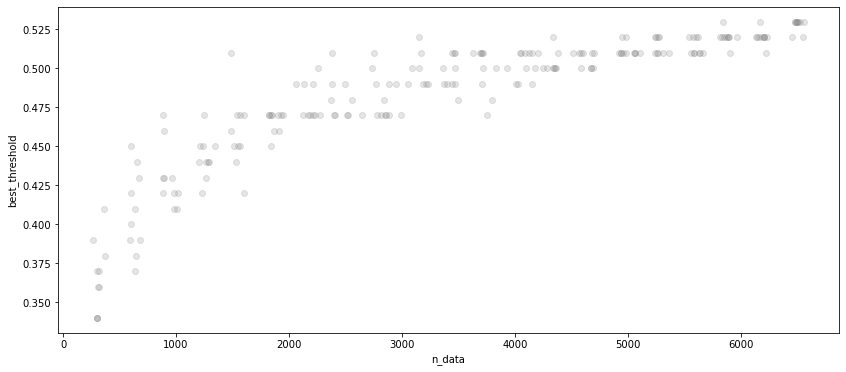

In [143]:
plt.figure(figsize=(14, 6))
plt.scatter(df_ret["n_data"].values,
            df_ret["best_th"].values, 
            alpha=0.2,
            color="gray")
plt.xlabel("n_data")
plt.ylabel("best_threshold")